In [1]:
#The Kaggle Dataset (https://www.kaggle.com/datasets/saurav9786/real-time-advertisers-auction)
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/saurav9786/real-time-advertisers-auction")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: christopherarubin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saurav9786/real-time-advertisers-auction


100%|██████████| 3.54M/3.54M [00:00<00:00, 495MB/s]

In [3]:
import pandas as pd
data = pd.read_csv("/content/real-time-advertisers-auction/Dataset.csv")
data.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,2019-06-30 00:00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,2019-06-30 00:00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,2019-06-30 00:00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,2019-06-30 00:00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,2019-06-30 00:00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
from google.cloud import bigquery

project_id = 'adstarschema'
dataset_id = 'adbidding'
table_id = 'your-bigquery-table-id' # This table_id might not be needed here, depending on how you use the client later.

client = bigquery.Client(project=project_id)

In [6]:
# Infer BigQuery schema from DataFrame
def infer_bigquery_schema(df):
    schema = []
    for col, dtype in df.dtypes.items():
        # Map pandas dtypes to BigQuery data types
        if dtype == 'object':
            bigquery_type = 'STRING'
        elif dtype == 'int64':
            bigquery_type = 'INTEGER'
        elif dtype == 'float64':
            bigquery_type = 'FLOAT'
        elif dtype == 'datetime64[ns]':
            bigquery_type = 'TIMESTAMP'
        elif dtype == 'bool':
            bigquery_type = 'BOOL'
        else:
            # Default to STRING for unhandled types
            bigquery_type = 'STRING'
        schema.append({'name': col, 'type': bigquery_type})
    return schema

bigquery_schema = infer_bigquery_schema(data)

# Print the schema in a format for BigQuery
import json
print(json.dumps(bigquery_schema, indent=2))

[
  {
    "name": "date",
    "type": "STRING"
  },
  {
    "name": "site_id",
    "type": "INTEGER"
  },
  {
    "name": "ad_type_id",
    "type": "INTEGER"
  },
  {
    "name": "geo_id",
    "type": "INTEGER"
  },
  {
    "name": "device_category_id",
    "type": "INTEGER"
  },
  {
    "name": "advertiser_id",
    "type": "INTEGER"
  },
  {
    "name": "order_id",
    "type": "INTEGER"
  },
  {
    "name": "line_item_type_id",
    "type": "INTEGER"
  },
  {
    "name": "os_id",
    "type": "INTEGER"
  },
  {
    "name": "integration_type_id",
    "type": "INTEGER"
  },
  {
    "name": "monetization_channel_id",
    "type": "INTEGER"
  },
  {
    "name": "ad_unit_id",
    "type": "INTEGER"
  },
  {
    "name": "total_impressions",
    "type": "INTEGER"
  },
  {
    "name": "total_revenue",
    "type": "FLOAT"
  },
  {
    "name": "viewable_impressions",
    "type": "INTEGER"
  },
  {
    "name": "measurable_impressions",
    "type": "INTEGER"
  },
  {
    "name": "revenue_share_percen

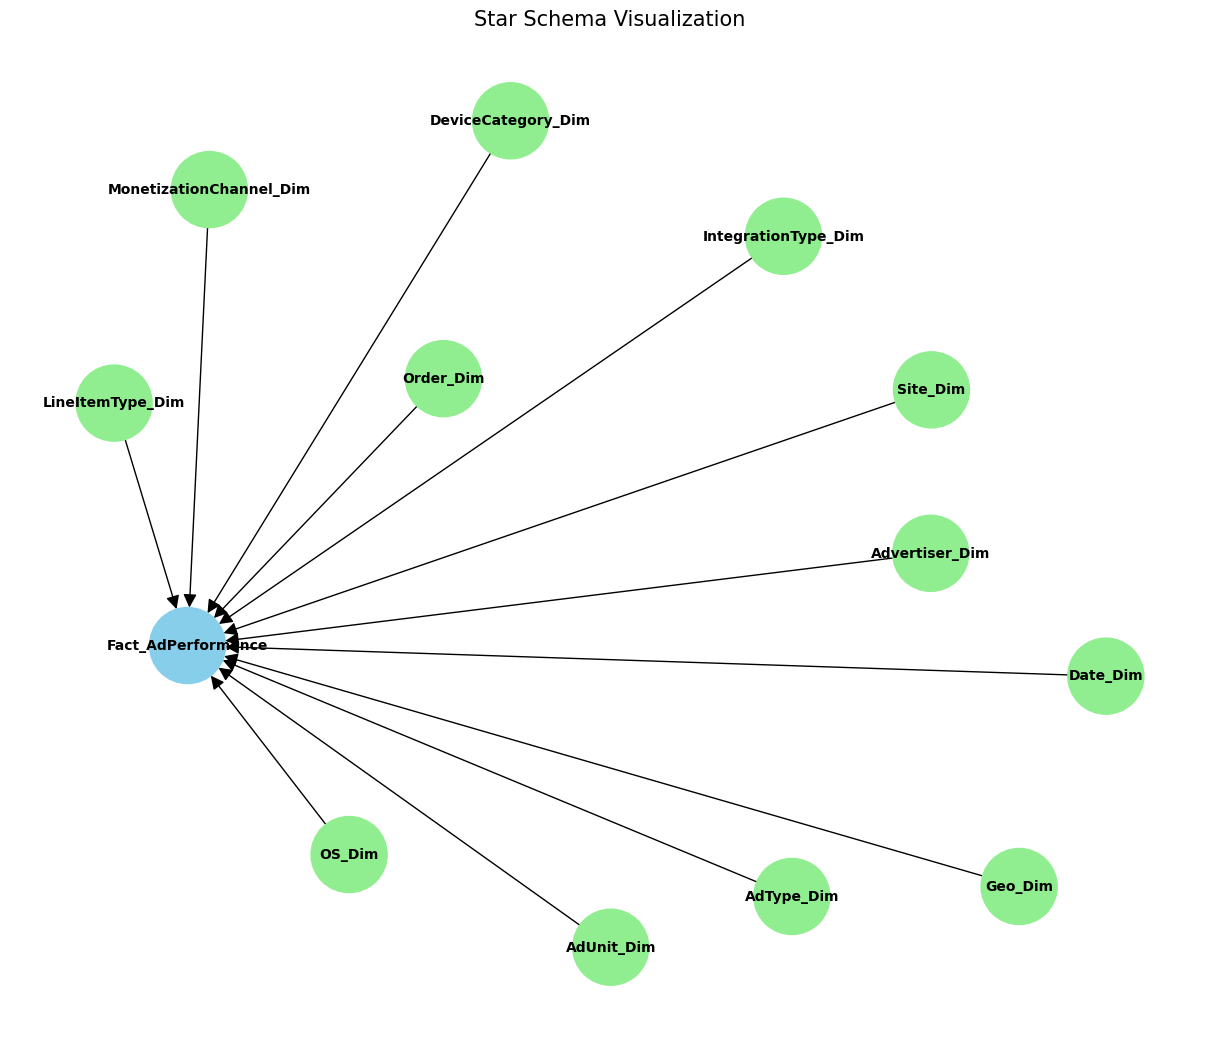

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# The Star Schema Structure
dimension_tables = {
    "Date_Dim": ["date_key", "date", "day", "month", "year"],
    "Site_Dim": ["site_key", "site_id"],
    "AdType_Dim": ["ad_type_key", "ad_type_id"],
    "Geo_Dim": ["geo_key", "geo_id"],
    "DeviceCategory_Dim": ["device_category_key", "device_category_id"],
    "Advertiser_Dim": ["advertiser_key", "advertiser_id"],
    "Order_Dim": ["order_key", "order_id"],
    "LineItemType_Dim": ["line_item_type_key", "line_item_type_id"],
    "OS_Dim": ["os_key", "os_id"],
    "IntegrationType_Dim": ["integration_type_key", "integration_type_id"],
    "MonetizationChannel_Dim": ["monetization_channel_key", "monetization_channel_id"],
    "AdUnit_Dim": ["ad_unit_key", "ad_unit_id"],
}

fact_table = {
    "Fact_AdPerformance": {
        "measures": ["total_impressions", "total_revenue", "viewable_impressions", "measurable_impressions", "revenue_share_percent"],
        "foreign_keys": [
            "date_key",
            "site_key",
            "ad_type_key",
            "geo_key",
            "device_category_key",
            "advertiser_key",
            "order_key",
            "line_item_type_key",
            "os_key",
            "integration_type_key",
            "monetization_channel_key",
            "ad_unit_key",
        ],
    }
}

# Create directed graph
G = nx.DiGraph()

# The nodes for the fact and dimension tables
fact_table_name = list(fact_table.keys())[0]
G.add_node(fact_table_name, node_type='fact')

for dim_name in dimension_tables.keys():
    G.add_node(dim_name, node_type='dimension')

# The edges from dimension tables to the fact table
for dim_name in dimension_tables.keys():
    G.add_edge(dim_name, fact_table_name)

# Node color mapping
color_map = []
for node in G:
    if G.nodes[node]['node_type'] == 'fact':
        color_map.append('skyblue')
    else:
        color_map.append('lightgreen')

# The node positions for a star layout
pos = nx.spring_layout(G, k=0.8, iterations=50) # Adjust k and iterations for layout

# Data Visualization (The actual infographic of the Star Schema)
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color=color_map, font_size=10, font_weight='bold', arrows=True, arrowsize=20)

# Titles/display the plot
plt.title("Star Schema Visualization", size=15)

# Save the plot to a file
plt.savefig("star_schema_visualization.png")

plt.show()

# Task
Transform the `data` DataFrame into a star schema and load the dimension and fact tables into BigQuery.

In [8]:
# The dimension tables
dimension_dfs = {}

# Process Date_Dim separately
data['date'] = pd.to_datetime(data['date'])
date_dim_df = data[['date']].drop_duplicates().reset_index(drop=True)
date_dim_df['date_key'] = date_dim_df.index + 1
date_dim_df['day'] = date_dim_df['date'].dt.day
date_dim_df['month'] = date_dim_df['date'].dt.month
date_dim_df['year'] = date_dim_df['date'].dt.year
dimension_dfs['Date_Dim'] = date_dim_df[['date_key', 'date', 'day', 'month', 'year']]

# Process other dimensions
for dim_name, columns in dimension_tables.items():
    if dim_name != 'Date_Dim':
        dim_key_col = columns[0]
        dim_id_col = columns[1]
        unique_dim_values = data[[dim_id_col]].drop_duplicates().reset_index(drop=True)
        unique_dim_values[dim_key_col] = unique_dim_values.index + 1
        dimension_dfs[dim_name] = unique_dim_values[[dim_key_col, dim_id_col]]

# Assign dimension dataframes to separate variables
for dim_name, df in dimension_dfs.items():
    globals()[f'{dim_name}_df'] = df

display(Date_Dim_df.head())
display(Site_Dim_df.head())
display(AdType_Dim_df.head())
display(Geo_Dim_df.head())
display(DeviceCategory_Dim_df.head())
display(Advertiser_Dim_df.head())
display(Order_Dim_df.head())
display(LineItemType_Dim_df.head())
display(OS_Dim_df.head())
display(IntegrationType_Dim_df.head())
display(MonetizationChannel_Dim_df.head())
display(AdUnit_Dim_df.head())

,date_key,date,day,month,year
0,1,2019-06-30,30,6,2019
1,2,2019-06-29,29,6,2019
2,3,2019-06-28,28,6,2019
3,4,2019-06-27,27,6,2019
4,5,2019-06-26,26,6,2019


,site_key,site_id
0,1,351
1,2,348
2,3,350
3,4,346
4,5,349


,ad_type_key,ad_type_id
0,1,10
1,2,17


,geo_key,geo_id
0,1,187
1,2,147
2,3,191
3,4,183
4,5,176


,device_category_key,device_category_id
0,1,2
1,2,3
2,3,1
3,4,5
4,5,4


,advertiser_key,advertiser_id
0,1,84
1,2,79
2,3,139
3,4,8
4,5,88


,order_key,order_id
0,1,3473
1,2,3463
2,3,3487
3,4,3485
4,5,45


,line_item_type_key,line_item_type_id
0,1,19
1,2,20
2,3,4
3,4,8
4,5,11


,os_key,os_id
0,1,60
1,2,58
2,3,59
3,4,56
4,5,55


,integration_type_key,integration_type_id
0,1,1


,monetization_channel_key,monetization_channel_id
0,1,4
1,2,19
2,3,1
3,4,2
4,5,21


,ad_unit_key,ad_unit_id
0,1,5174
1,2,5138
2,3,5144
3,4,5169
4,5,5177


In [9]:
# Copy of the original data for the fact table
fact_table_df = data.copy()

# Merge with Date_Dim
fact_table_df = pd.merge(fact_table_df, dimension_dfs['Date_Dim'][['date', 'date_key']], on='date', how='left')
fact_table_df = fact_table_df.drop('date', axis=1)

# Merge with other dimension tables
for dim_name, columns in dimension_tables.items():
    if dim_name != 'Date_Dim':
        dim_key_col = columns[0]
        dim_id_col = columns[1]
        fact_table_df = pd.merge(fact_table_df, dimension_dfs[dim_name][[dim_id_col, dim_key_col]], on=dim_id_col, how='left')
        fact_table_df = fact_table_df.drop(dim_id_col, axis=1)

# Measure columns and foreign keys for the final fact table
measure_columns = fact_table['Fact_AdPerformance']['measures']
foreign_key_columns = fact_table['Fact_AdPerformance']['foreign_keys']

fact_table_df = fact_table_df[foreign_key_columns + measure_columns]

# Test the first few rows of the fact table
display(fact_table_df.head())

,date_key,site_key,ad_type_key,geo_key,device_category_key,advertiser_key,order_key,line_item_type_key,os_key,integration_type_key,monetization_channel_key,ad_unit_key,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,1,1,1,1,1,1,1,1,1,1,1,1,16,0.0,2,16,1
1,1,1,1,1,1,1,1,1,2,1,1,1,6,0.0,0,6,1
2,1,1,1,2,1,1,1,1,1,1,1,1,4,0.0,0,4,1
3,1,1,1,2,1,1,1,1,2,1,1,1,4,0.0,0,4,1
4,1,2,1,2,2,2,2,2,3,1,2,2,4,0.0,0,4,1


In [10]:
for dim_name, df in dimension_dfs.items():
    table_id = f'{project_id}.{dataset_id}.{dim_name}'
    df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f'Loaded {dim_name} into BigQuery table: {table_id}')

/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 5171.77it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Date_Dim into BigQuery table: adstarschema.adbidding.Date_Dim


100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Site_Dim into BigQuery table: adstarschema.adbidding.Site_Dim


100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded AdType_Dim into BigQuery table: adstarschema.adbidding.AdType_Dim


100%|██████████| 1/1 [00:00<00:00, 10433.59it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Geo_Dim into BigQuery table: adstarschema.adbidding.Geo_Dim


100%|██████████| 1/1 [00:00<00:00, 8144.28it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded DeviceCategory_Dim into BigQuery table: adstarschema.adbidding.DeviceCategory_Dim


100%|██████████| 1/1 [00:00<00:00, 7503.23it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Advertiser_Dim into BigQuery table: adstarschema.adbidding.Advertiser_Dim


100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Order_Dim into BigQuery table: adstarschema.adbidding.Order_Dim


100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded LineItemType_Dim into BigQuery table: adstarschema.adbidding.LineItemType_Dim


100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded OS_Dim into BigQuery table: adstarschema.adbidding.OS_Dim


100%|██████████| 1/1 [00:00<00:00, 10538.45it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded IntegrationType_Dim into BigQuery table: adstarschema.adbidding.IntegrationType_Dim


100%|██████████| 1/1 [00:00<00:00, 10951.19it/s]
/tmp/ipython-input-2491267320.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded MonetizationChannel_Dim into BigQuery table: adstarschema.adbidding.MonetizationChannel_Dim


100%|██████████| 1/1 [00:00<00:00, 1279.92it/s]

Loaded AdUnit_Dim into BigQuery table: adstarschema.adbidding.AdUnit_Dim


In [11]:
# Replace with your actual project ID and dataset ID
project_id = 'adstarschema'
dataset_id = 'adbidding'

for dim_name, df in dimension_dfs.items():
    table_id = f'{project_id}.{dataset_id}.{dim_name}'
    df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f'Loaded {dim_name} into BigQuery table: {table_id}')

/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9362.29it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Date_Dim into BigQuery table: adstarschema.adbidding.Date_Dim


100%|██████████| 1/1 [00:00<00:00, 5229.81it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Site_Dim into BigQuery table: adstarschema.adbidding.Site_Dim


100%|██████████| 1/1 [00:00<00:00, 12228.29it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded AdType_Dim into BigQuery table: adstarschema.adbidding.AdType_Dim


100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Geo_Dim into BigQuery table: adstarschema.adbidding.Geo_Dim


100%|██████████| 1/1 [00:00<00:00, 12336.19it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded DeviceCategory_Dim into BigQuery table: adstarschema.adbidding.DeviceCategory_Dim


100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Advertiser_Dim into BigQuery table: adstarschema.adbidding.Advertiser_Dim


100%|██████████| 1/1 [00:00<00:00, 10512.04it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Order_Dim into BigQuery table: adstarschema.adbidding.Order_Dim


100%|██████████| 1/1 [00:00<00:00, 10381.94it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded LineItemType_Dim into BigQuery table: adstarschema.adbidding.LineItemType_Dim


100%|██████████| 1/1 [00:00<00:00, 8439.24it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded OS_Dim into BigQuery table: adstarschema.adbidding.OS_Dim


100%|██████████| 1/1 [00:00<00:00, 2864.96it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded IntegrationType_Dim into BigQuery table: adstarschema.adbidding.IntegrationType_Dim


100%|██████████| 1/1 [00:00<00:00, 9799.78it/s]
/tmp/ipython-input-2949249688.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded MonetizationChannel_Dim into BigQuery table: adstarschema.adbidding.MonetizationChannel_Dim


100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]

Loaded AdUnit_Dim into BigQuery table: adstarschema.adbidding.AdUnit_Dim


In [12]:
#BigQuery
project_id = 'adstarschema' # Replace with your actual project ID
dataset_id = 'adbidding' # Replace with your actual dataset ID

for dim_name, df in dimension_dfs.items():
    table_id = f'{project_id}.{dataset_id}.{dim_name}'
    df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f'Loaded {dim_name} into BigQuery table: {table_id}')

/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Date_Dim into BigQuery table: adstarschema.adbidding.Date_Dim


100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Site_Dim into BigQuery table: adstarschema.adbidding.Site_Dim


100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded AdType_Dim into BigQuery table: adstarschema.adbidding.AdType_Dim


100%|██████████| 1/1 [00:00<00:00, 10591.68it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Geo_Dim into BigQuery table: adstarschema.adbidding.Geo_Dim


100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded DeviceCategory_Dim into BigQuery table: adstarschema.adbidding.DeviceCategory_Dim


100%|██████████| 1/1 [00:00<00:00, 12300.01it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Advertiser_Dim into BigQuery table: adstarschema.adbidding.Advertiser_Dim


100%|██████████| 1/1 [00:00<00:00, 9776.93it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded Order_Dim into BigQuery table: adstarschema.adbidding.Order_Dim


100%|██████████| 1/1 [00:00<00:00, 11650.84it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded LineItemType_Dim into BigQuery table: adstarschema.adbidding.LineItemType_Dim


100%|██████████| 1/1 [00:00<00:00, 11983.73it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded OS_Dim into BigQuery table: adstarschema.adbidding.OS_Dim


100%|██████████| 1/1 [00:00<00:00, 8224.13it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded IntegrationType_Dim into BigQuery table: adstarschema.adbidding.IntegrationType_Dim


100%|██████████| 1/1 [00:00<00:00, 2721.81it/s]
/tmp/ipython-input-3782959600.py:7: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')


Loaded MonetizationChannel_Dim into BigQuery table: adstarschema.adbidding.MonetizationChannel_Dim


100%|██████████| 1/1 [00:00<00:00, 2603.54it/s]

Loaded AdUnit_Dim into BigQuery table: adstarschema.adbidding.AdUnit_Dim


In [13]:
table_id = f'{project_id}.{dataset_id}.Fact_AdPerformance'
fact_table_df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
print(f'Loaded Fact_AdPerformance into BigQuery table: {table_id}')

/tmp/ipython-input-2881411551.py:2: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  fact_table_df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 11459.85it/s]

Loaded Fact_AdPerformance into BigQuery table: adstarschema.adbidding.Fact_AdPerformance


In [14]:
import pandas_gbq

project_id = 'adstarschema'
dataset_id = 'adbidding'

for dim_name, df in dimension_dfs.items():
    table_id = f'{project_id}.{dataset_id}.{dim_name}'
    pandas_gbq.to_gbq(df, destination_table=table_id, project_id=project_id, if_exists='replace')
    print(f'Loaded {dim_name} into BigQuery table: {table_id}')

100%|██████████| 1/1 [00:00<00:00, 11781.75it/s]


Loaded Date_Dim into BigQuery table: adstarschema.adbidding.Date_Dim


100%|██████████| 1/1 [00:00<00:00, 11748.75it/s]


Loaded Site_Dim into BigQuery table: adstarschema.adbidding.Site_Dim


100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Loaded AdType_Dim into BigQuery table: adstarschema.adbidding.AdType_Dim


100%|██████████| 1/1 [00:00<00:00, 13025.79it/s]


Loaded Geo_Dim into BigQuery table: adstarschema.adbidding.Geo_Dim


100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Loaded DeviceCategory_Dim into BigQuery table: adstarschema.adbidding.DeviceCategory_Dim


100%|██████████| 1/1 [00:00<00:00, 11715.93it/s]


Loaded Advertiser_Dim into BigQuery table: adstarschema.adbidding.Advertiser_Dim


100%|██████████| 1/1 [00:00<00:00, 10618.49it/s]


Loaded Order_Dim into BigQuery table: adstarschema.adbidding.Order_Dim


100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Loaded LineItemType_Dim into BigQuery table: adstarschema.adbidding.LineItemType_Dim


100%|██████████| 1/1 [00:00<00:00, 10727.12it/s]


Loaded OS_Dim into BigQuery table: adstarschema.adbidding.OS_Dim


100%|██████████| 1/1 [00:00<00:00, 9597.95it/s]


Loaded IntegrationType_Dim into BigQuery table: adstarschema.adbidding.IntegrationType_Dim


100%|██████████| 1/1 [00:00<00:00, 11037.64it/s]


Loaded MonetizationChannel_Dim into BigQuery table: adstarschema.adbidding.MonetizationChannel_Dim


100%|██████████| 1/1 [00:00<00:00, 7570.95it/s]

Loaded AdUnit_Dim into BigQuery table: adstarschema.adbidding.AdUnit_Dim


In [15]:
table_id = f'{project_id}.{dataset_id}.Fact_AdPerformance'
fact_table_df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
print(f'Loaded Fact_AdPerformance into BigQuery table: {table_id}')

/tmp/ipython-input-2881411551.py:2: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  fact_table_df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9467.95it/s]

Loaded Fact_AdPerformance into BigQuery table: adstarschema.adbidding.Fact_AdPerformance


In [16]:
project_id = 'adstarschema'
dataset_id = 'adbidding'

# The full destination table ID
fact_table_full_id = f'{project_id}.{dataset_id}.Fact_AdPerformance'

# Load the fact table DataFrame into BigQuery
fact_table_df.to_gbq(destination_table=fact_table_full_id, project_id=project_id, if_exists='replace')

# Print confirmation message
print(f'Loaded Fact_AdPerformance into BigQuery table: {fact_table_full_id}')

/tmp/ipython-input-3926927178.py:8: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  fact_table_df.to_gbq(destination_table=fact_table_full_id, project_id=project_id, if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]

Loaded Fact_AdPerformance into BigQuery table: adstarschema.adbidding.Fact_AdPerformance


In [17]:
%%bigquery --project adstarschema
-- Create Date_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Date_Dim` (
    date_key INT64,
    date DATE,
    day INT64,
    month INT64,
    year INT64
);

-- Create Site_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Site_Dim` (
    site_key INT64,
    site_id INT64
);

-- Create AdType_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.AdType_Dim` (
    ad_type_key INT64,
    ad_type_id INT64
);

-- Create Geo_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Geo_Dim` (
    geo_key INT64,
    geo_id INT64
);

-- Create DeviceCategory_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.DeviceCategory_Dim` (
    device_category_key INT64,
    device_category_id INT64
);

-- Create Advertiser_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Advertiser_Dim` (
    advertiser_key INT64,
    advertiser_id INT64
);

-- Create Order_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Order_Dim` (
    order_key INT64,
    order_id INT64
);

-- Create LineItemType_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.LineItemType_Dim` (
    line_item_type_key INT64,
    line_item_type_id INT64
);

-- Create OS_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.OS_Dim` (
    os_key INT64,
    os_id INT64
);

-- Create IntegrationType_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.IntegrationType_Dim` (
    integration_type_key INT64,
    integration_type_id INT64
);

-- Create MonetizationChannel_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.MonetizationChannel_Dim` (
    monetization_channel_key INT64,
    monetization_channel_id INT64
);

-- Create AdUnit_Dim table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.AdUnit_Dim` (
    ad_unit_key INT64,
    ad_unit_id INT64
);

-- Create Fact_AdPerformance table
CREATE TABLE IF NOT EXISTS `adstarschema.adbidding.Fact_AdPerformance` (
    date_key INT64,
    site_key INT64,
    ad_type_key INT64,
    geo_key INT64,
    device_category_key INT64,
    advertiser_key INT64,
    order_key INT64,
    line_item_type_key INT64,
    os_key INT64,
    integration_type_key INT64,
    monetization_channel_key INT64,
    ad_unit_key INT64,
    total_impressions INT64,
    total_revenue FLOAT64,
    viewable_impressions INT64,
    measurable_impressions INT64,
    revenue_share_percent INT64
);

Query is running:   0%|          |

""
